In [14]:
import warnings
warnings.filterwarnings('ignore')
#Import general libraries (needed for functions)
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pickle as pk

#Import Qiskit classes classes
import qiskit
from qiskit import IBMQ
from qiskit import Aer

from qiskit.compiler import transpile, assemble
from qiskit.result import marginal_counts as margct
from qiskit.circuit.exceptions import CircuitError
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import mcm_rb_circuits as mcmrb

In [15]:
rb_q_list1 = sorted([2,5,4,10,13,11,16,17,15,21,24,22])
ancilla_q_list1 = sorted([3,7,14,18,25])
rb_q_list2 = sorted([2,4,10,15,13,5,11,9,16,22,21,24])
ancilla_q_list2 = sorted([1,12,8,23,19])

In [16]:
seeds = 40
xval = np.insert(np.ceil(np.geomspace(1,150,14)).astype(int),0,0)
print(xval)

[  0   1   2   3   4   5   7  11  15  22  33  48  70 103 150]


In [17]:
full_q_list_1 = rb_q_list1+ancilla_q_list1
full_q_list_2 = rb_q_list2+ancilla_q_list2
shots = 1024

In [18]:
def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pk.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

In [19]:
config1_data = load_object("exp_config1.pickle")
#print(config1_data)
config2_data = load_object("exp_config2.pickle")

In [20]:
xvals042622_1 = config1_data[0]
rb_res042622_1 = config1_data[1]
fits042622_1 = config1_data[2]
lfits042622_1 = config1_data[3]

xvals042622_2 = config2_data[0]
rb_res042622_2 = config2_data[1]
fits042622_2 = config2_data[2]
lfits042622_2 = config2_data[3]

In [21]:
temp_len = len(xvals042622_1)
data_1 = np.zeros([3,len(full_q_list_1),seeds,temp_len])
for exp_ind in range(0,3):
    for i in range(seeds):
        for qn in range(0,len(full_q_list_1)):
            data_1[exp_ind,qn,i,:] = rb_res042622_1['rb_res_%d_%d'%(exp_ind,qn)][i*temp_len:(i+1)*temp_len]

In [22]:
temp_len = len(xvals042622_2)
data_2 = np.zeros([3,len(full_q_list_2),seeds,temp_len])
for exp_ind in range(0,3):
    for i in range(seeds):
        for qn in range(0,len(full_q_list_2)):
            data_2[exp_ind,qn,i,:] = rb_res042622_2['rb_res_%d_%d'%(exp_ind,qn)][i*temp_len:(i+1)*temp_len]

## Plotting

### Figure 2

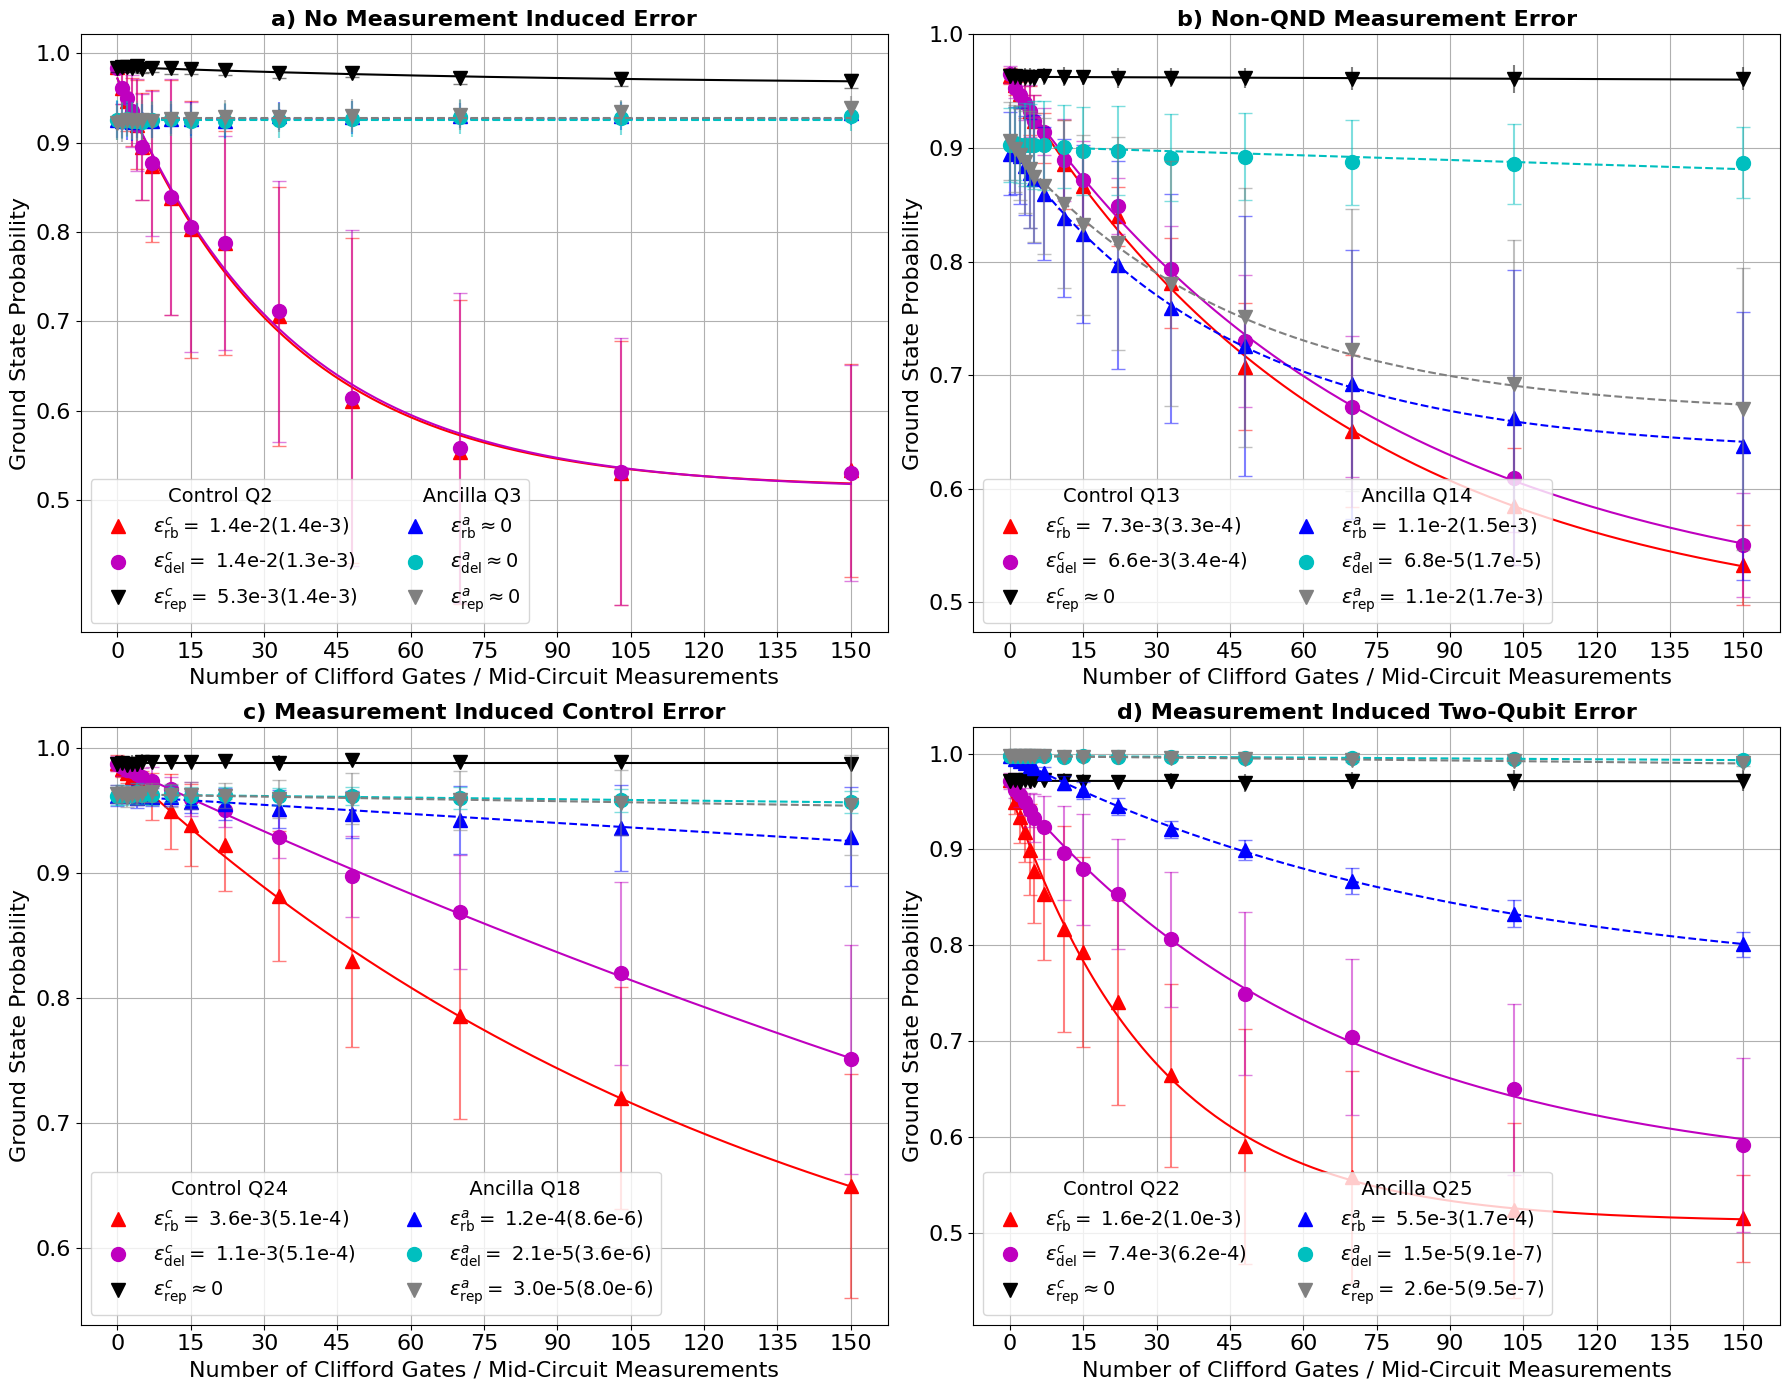

In [23]:
fig, ax = plt.subplots(2,2,figsize=(18,14))


i0 = 0
i1 = 1
fsize = 16
fsizel = 14
msize = 10

# No error

xval = xvals042622_1
fits = fits042622_1
data = data_1
colours = ['r','m','k','b','c','grey']
labels = ['c','a']
markers = ["^","o","v"]
exps = [r'\rm rb',r'\rm del',r'\rm rep']
lstyles = ['-','--','--']

q_list = full_q_list_1
qs = [2,3]

fxval = np.arange(xval[0],xval[-1]+1,1)

for (k, q) in enumerate(qs):
    temp_ind = np.where(np.array(q_list)==q)[0][0]
    for j in range(3):
        
        std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
        alpha = fits['fit_%d_%d'%(j,temp_ind)][0][1]
        alpha_err = std_errs[1]
        epc = (1-alpha)/2
        epc_err = 1/2*alpha_err
        
#         print(fits['fit_%d_%d'%(j,temp_ind)][0])
        
        if epc < 1e-8:
            ax[i0,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
            ax[i0,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
        else:
            ax[i0,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
            ax[i0,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))
    
        ax[i0,i0].plot(fxval, mcmrb.expfunction_alpha(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])

leg = ax[i0,i0].legend(ncol = 2,title='Control Q2                        Ancilla Q3',fontsize=fsizel,title_fontsize=fsizel)   
leg._legend_box.align = "right"
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[i0,i0].set_ylabel('Ground State Probability',fontsize=fsize)
ax[i0,i0].set_xlabel('Number of Clifford Gates / Mid-Circuit Measurements',fontsize=fsize)
ax[i0,i0].set_title('a) No Measurement Induced Error',fontsize=fsize,fontweight="bold")
ax[i0,i0].set_xticks(range(0,160,15))
ax[i0,i0].set_xticklabels(range(0,160,15),fontsize=fsize)
ax[i0,i0].set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
ax[i0,i0].set_yticklabels([0.5,0.6,0.7,0.8,0.9,1.0],fontsize=fsize)
ax[i0,i0].grid('minor')

# non-QND

xval = xvals042622_1
data = data_1
colours = ['r','m','k','b','c','grey']
labels = ['c','a']
markers = ["^","o","v"]
exps = [r'\rm rb',r'\rm del',r'\rm rep']
lstyles = ['-','--','--']

q_list = full_q_list_1
# qs = [21,19]
qs = [13,14]

fxval = np.arange(xval[0],xval[-1]+1,1)

expfit = [True, True, False, True, False, True]
epc_limit = 1e-5

for (k, q) in enumerate(qs):
    temp_ind = np.where(np.array(q_list)==q)[0][0]
    for j in range(3):
        
        if expfit[3*k+j]:
            # exponential
            fits = fits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = fits['fit_%d_%d'%(j,temp_ind)][0][1]
            alpha_err = std_errs[1]
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err

            if epc < epc_limit:
                ax[i0,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i0,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i0,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i0,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

            ax[i0,i1].plot(fxval, mcmrb.expfunction_alpha(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])
            
        else:
            # linear
            fits = lfits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = np.exp(-fits['fit_%d_%d'%(j,temp_ind)][0][0])
            alpha_err = std_errs[0]*alpha
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err


            if epc < epc_limit:
                ax[i0,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i0,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i0,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i0,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

            ax[i0,i1].plot(fxval, mcmrb.linearfunction(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])

ax[i0,i1].legend(loc=3,ncol = 2,title='Control Q13                             Ancilla Q14',fontsize=fsizel,title_fontsize=fsizel)   
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[i0,i1].set_ylabel('Ground State Probability',fontsize=fsize)
ax[i0,i1].set_xlabel('Number of Clifford Gates / Mid-Circuit Measurements',fontsize=fsize)
ax[i0,i1].set_title('b) Non-QND Measurement Error',fontsize=fsize,fontweight="bold")
ax[i0,i1].set_xticks(range(0,160,15))
ax[i0,i1].set_xticklabels(range(0,160,15),fontsize=fsize)
ax[i0,i1].set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
ax[i0,i1].set_yticklabels([0.5,0.6,0.7,0.8,0.9,1.0],fontsize=fsize)
ax[i0,i1].grid('minor')

# Stark

xval = xvals042622_1
data = data_1
colours = ['r','m','k','b','c','grey']
labels = ['c','a']
markers = ["^","o","v"]
exps = [r'\rm rb',r'\rm del',r'\rm rep']
lstyles = ['-','--','--']

q_list = full_q_list_1
# qs = [15,12]
qs = [24,18]

fxval = np.arange(xval[0],xval[-1]+1,1)

expfit = [True, True, False, False, False, False]
epc_limit = 1e-5

for (k, q) in enumerate(qs):
    temp_ind = np.where(np.array(q_list)==q)[0][0]
    for j in range(3):
        
        if expfit[3*k+j]:
            # exponential
            fits = fits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = fits['fit_%d_%d'%(j,temp_ind)][0][1]
            alpha_err = std_errs[1]
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err

            if epc < epc_limit:
                ax[i1,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i1,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

            ax[i1,i0].plot(fxval, mcmrb.expfunction_alpha(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])
            
        else:
            # linear
            fits = lfits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = np.exp(-fits['fit_%d_%d'%(j,temp_ind)][0][0])
            alpha_err = std_errs[0]*alpha
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err


            if epc < epc_limit:
                ax[i1,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i1,i0].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i0].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

            ax[i1,i0].plot(fxval, mcmrb.linearfunction(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])

ax[i1,i0].legend(ncol = 2,title='Control Q24                             Ancilla Q18',fontsize=fsizel,title_fontsize=fsizel)   
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[i1,i0].set_ylabel('Ground State Probability',fontsize=fsize)
ax[i1,i0].set_xlabel('Number of Clifford Gates / Mid-Circuit Measurements',fontsize=fsize)
ax[i1,i0].set_xticks(range(0,160,15))
ax[i1,i0].set_xticklabels(range(0,160,15),fontsize=fsize)
ax[i1,i0].set_yticks([0.6,0.7,0.8,0.9,1.0])
ax[i1,i0].set_yticklabels([0.6,0.7,0.8,0.9,1.0],fontsize=fsize)
ax[i1,i0].grid('minor')
ax[i1,i0].set_title('c) Measurement Induced Control Error',fontsize=fsize,fontweight="bold")


# Collision

xval = xvals042622_1
data = data_1
colours = ['r','m','k','b','c','grey']
labels = ['c','a']
markers = ["^","o","v"]
exps = [r'\rm rb',r'\rm del',r'\rm rep']
lstyles = ['-','--','--']

q_list = full_q_list_1
qs = [22,25]

fxval = np.arange(xval[0],xval[-1]+1,1)

expfit = [True, True, False, True, False, False]
epc_limit = 1e-5

for (k, q) in enumerate(qs):
    temp_ind = np.where(np.array(q_list)==q)[0][0]
    for j in range(3):
        
        if expfit[3*k+j]:
            # exponential
            fits = fits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = fits['fit_%d_%d'%(j,temp_ind)][0][1]
            alpha_err = std_errs[1]
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err

            if epc < epc_limit:
                ax[i1,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i1,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

                
            ax[i1,i1].plot(fxval, mcmrb.expfunction_alpha(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])
            
        else:
            # linear
            fits = lfits042622_1
            std_errs = np.sqrt(np.diag(fits['fit_%d_%d'%(j,temp_ind)][1]))
            alpha = np.exp(-fits['fit_%d_%d'%(j,temp_ind)][0][0])
            alpha_err = std_errs[0]*alpha
            epc = (1-alpha)/2
            epc_err = 1/2*alpha_err


            if epc < epc_limit:
                ax[i1,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= r'$\epsilon^{%s}_{%s} \approx 0$'%(labels[k],exps[j]))
            else:
                ax[i1,i1].errorbar(xval, np.mean(data[j,temp_ind,:,:],0)/shots,yerr=np.std(data[j,temp_ind,:,:],0)/shots,alpha = 0.5,capsize=5,linestyle='',markersize=msize, marker='',color=colours[3*k+j])
                ax[i1,i1].plot(xval, np.mean(data[j,temp_ind,:,:],0)/shots,linestyle='',markersize=msize, marker=markers[j],color=colours[3*k+j],label= format(r'$\epsilon^{%s}_{%s} = $'%(labels[k],exps[j]) +' %.1e(%.1e)'%(epc,epc_err)).replace('e-0','e-'))

            ax[i1,i1].plot(fxval, mcmrb.linearfunction(fxval,*fits['fit_%d_%d'%(j,temp_ind)][0]),linestyle=lstyles[k], marker='',color=colours[3*k+j])


ax[i1,i1].legend(loc=3,ncol = 2,title='Control Q22                             Ancilla Q25',fontsize=fsizel,title_fontsize=fsizel)   
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[i1,i1].set_ylabel('Ground State Probability',fontsize=fsize)
ax[i1,i1].set_xlabel('Number of Clifford Gates / Mid-Circuit Measurements',fontsize=fsize)
ax[i1,i1].set_xticks(range(0,160,15))
ax[i1,i1].set_xticklabels(range(0,160,15),fontsize=fsize)
ax[i1,i1].set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
ax[i1,i1].set_yticklabels([0.5,0.6,0.7,0.8,0.9,1.0],fontsize=fsize)
ax[i1,i1].set_title('d) Measurement Induced Two-Qubit Error',fontsize=fsize,fontweight="bold")
ax[i1,i1].grid('minor')

plt.tight_layout();

# plt.savefig('Plots/All_signatures_042622_linear.pdf',facecolor=(1, 1, 1),bbox_inches='tight')

### Figure 8 and 9

In [24]:
def epc_and_err_exp(fit):
    std_errs = np.sqrt(np.diag(fit[1]))
    alpha = fit[0][1]
    alpha_err = std_errs[1]
    epc = (1-alpha)/2
    epc_err = 1/2*alpha_err
    
    return (epc,epc_err)

def epc_and_err_lin(fit):
    std_errs = np.sqrt(np.diag(fit[1]))
    alpha = np.exp(-fit[0][0])
    alpha_err = std_errs[0]*alpha
    epc = (1-alpha)/2
    epc_err = 1/2*alpha_err
    
    return (epc,epc_err)

In [12]:
con_1 = data_1[:,0:12,:,:]
anc_1 = data_1[:,12:17,:,:]

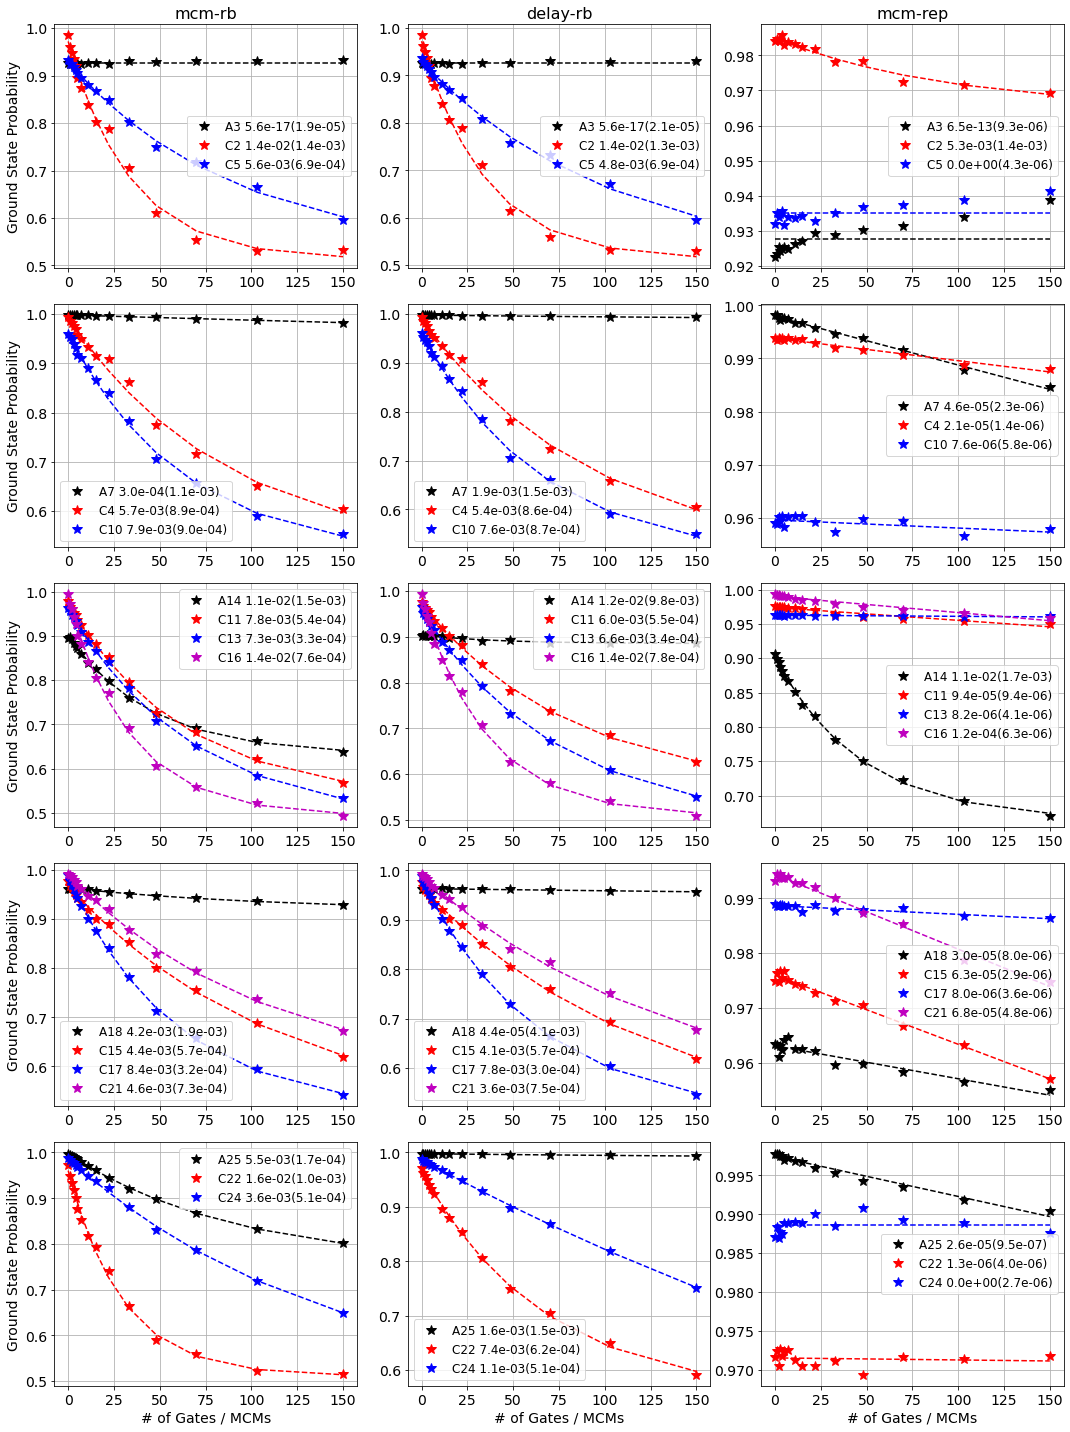

In [13]:
fig, ax = plt.subplots(5,3,figsize=(15,20))
titles = ['mcm-rb','delay-rb','mcm-rep']
xvals = xvals042622_1
efits = fits042622_1
lfits = lfits042622_1
rb_q_list_temp = rb_q_list1
ancilla_q_list_temp = ancilla_q_list1
anc_temp = anc_1
con_temp = con_1

fsize = 14
fsize2 = 12
msize = 10

#1
row = 0
anc = 0
c1 = 0
c2 = 2
for i in range(3):
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    ax[row,i].set_title(titles[i],fontsize=16)
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')
    
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%epc_and_err_exp(efits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, mcmrb.expfunction_alpha(xvals,*efits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#2
row = 1
anc = 1
c1 = 1
c2 = 3
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#3
row = 2
anc = 2
c1 = 4
c2 = 5
c3 = 7
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %epc_and_err_exp(efits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, mcmrb.expfunction_alpha(xvals,*efits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].plot(xvals, np.mean(con_temp[i,c3,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='m',label='C%d'%rb_q_list_temp[c3] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c3)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c3)][0]),linestyle='--', marker='',color='m')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#4
row = 3
anc = 3
c1 = 6
c2 = 8
c3 = 9
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].plot(xvals, np.mean(con_temp[i,c3,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='m',label='C%d'%rb_q_list_temp[c3] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c3)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c3)][0]),linestyle='--', marker='',color='m')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#5
row = 4
anc = 4
c1 = 10
c2 = 11

for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
        
    ax[row,i].set_xlabel('# of Gates / MCMs',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)


plt.tight_layout();

# plt.savefig('Plots/Config1_042622.pdf',facecolor=(1, 1, 1),bbox_inches='tight')

In [25]:
con_2 = data_2[:,0:12,:,:]
anc_2 = data_2[:,12:17,:,:]

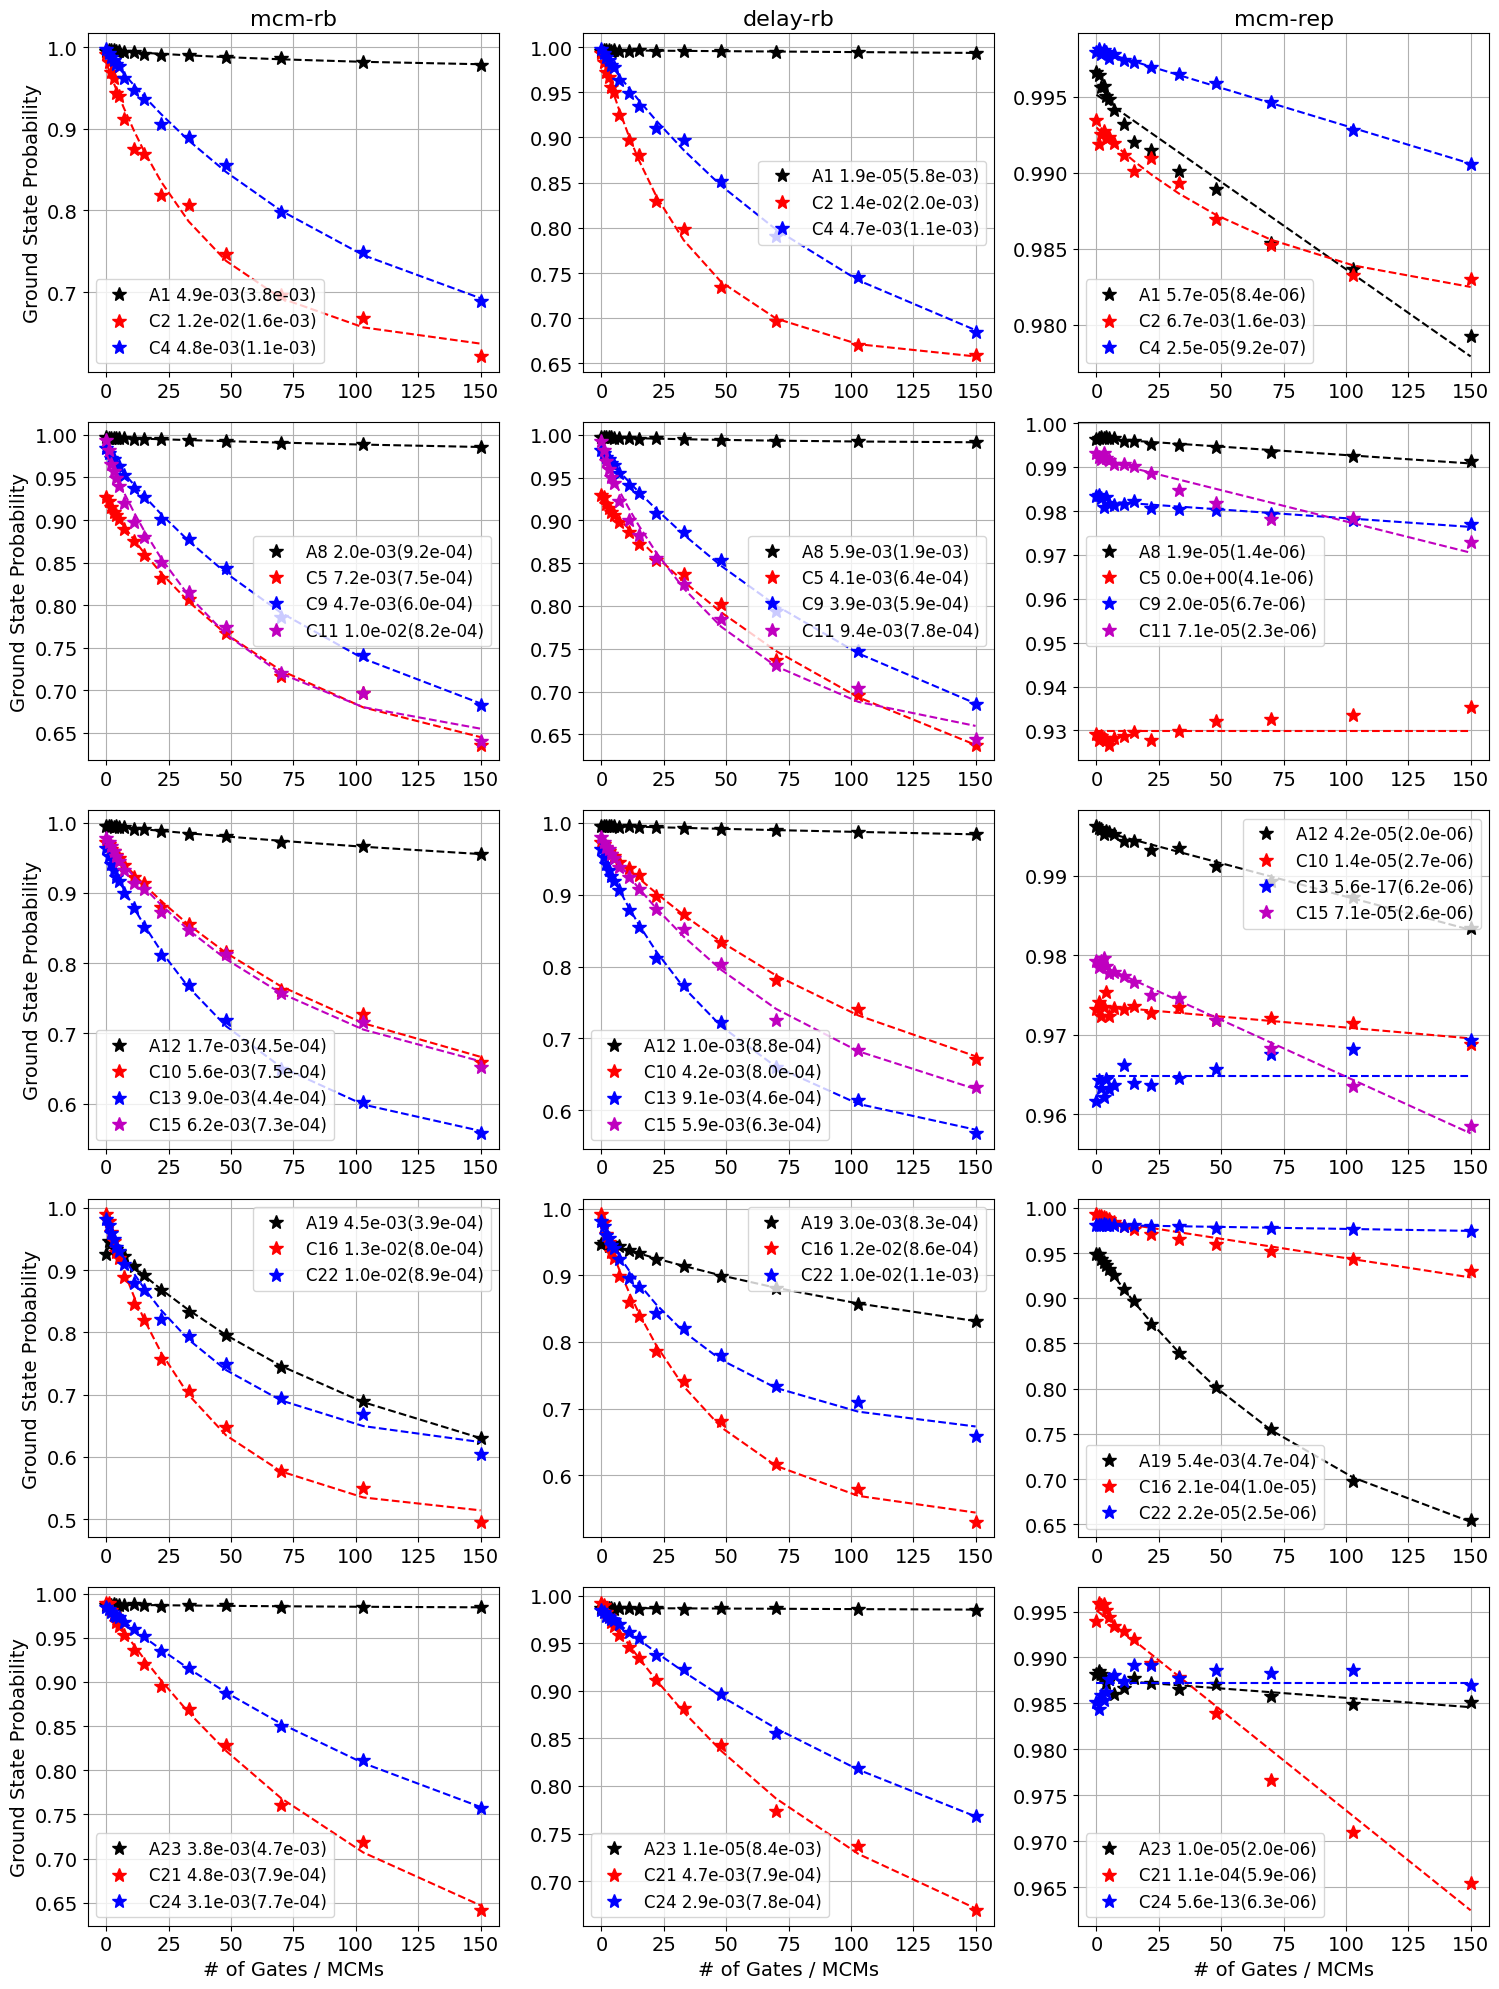

In [26]:
fig, ax = plt.subplots(5,3,figsize=(15,20))
titles = ['mcm-rb','delay-rb','mcm-rep']
xvals = xvals042622_2
efits = fits042622_2
lfits = lfits042622_2
rb_q_list_temp = rb_q_list2
ancilla_q_list_temp = ancilla_q_list2
anc_temp = anc_2
con_temp = con_2


fsize = 14
fsize2 = 12
msize = 10

#1
row = 0
anc = 0
c1 = 0
c2 = 1
for i in range(3):
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    ax[row,i].set_title(titles[i],fontsize=16)
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')
    
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%epc_and_err_exp(efits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, mcmrb.expfunction_alpha(xvals,*efits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#2
row = 1
anc = 1
c1 = 2
c2 = 3
c3 = 5
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].plot(xvals, np.mean(con_temp[i,c3,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='m',label='C%d'%rb_q_list_temp[c3] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c3)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c3)][0]),linestyle='--', marker='',color='m')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#3
row = 2
anc = 2
c1 = 4
c2 = 6
c3 = 7
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%epc_and_err_exp(efits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, mcmrb.expfunction_alpha(xvals,*efits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].plot(xvals, np.mean(con_temp[i,c3,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='m',label='C%d'%rb_q_list_temp[c3] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c3)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c3)][0]),linestyle='--', marker='',color='m')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#4
row = 3
anc = 3
c1 = 8
c2 = 10
for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %epc_and_err_exp(efits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, mcmrb.expfunction_alpha(xvals,*efits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)

#5
row = 4
anc = 4
c1 = 9
c2 = 11

for i in range(3):
    if i == 0:
        ax[row,i].set_ylabel('Ground State Probability',fontsize=fsize)
        
    ax[row,i].set_xlabel('# of Gates / MCMs',fontsize=fsize)
    
    if i == 2:
        fits = lfits
        tempf = mcmrb.linearfunction
        tempE = epc_and_err_lin
    else:
        fits = efits
        tempf = mcmrb.expfunction_alpha
        tempE = epc_and_err_exp
    
    ax[row,i].plot(xvals, np.mean(anc_temp[i,anc,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='k',label='A%d'%ancilla_q_list_temp[anc] + ' %.1e(%.1e)' %tempE(fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,anc+len(rb_q_list_temp))][0]),linestyle='--', marker='',color='k')

    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c1,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='r',label='C%d'%rb_q_list_temp[c1] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c1)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c1)][0]),linestyle='--', marker='',color='r')
    
    ax[row,i].plot(xvals, np.mean(con_temp[i,c2,:,:],0)/shots,linestyle='', marker='*',markersize=msize,color='b',label='C%d'%rb_q_list_temp[c2] + ' %.1e(%.1e)'%tempE(fits['fit_%d_%d'%(i,c2)]))
    ax[row,i].plot(xvals, tempf(xvals,*fits['fit_%d_%d'%(i,c2)][0]),linestyle='--', marker='',color='b')

    ax[row,i].legend(fontsize=fsize2)
    ax[row,i].grid('minor')
    ax[row,i].tick_params(axis='both', which='major', labelsize=fsize)


plt.tight_layout();

# plt.savefig('Plots/Config2_042622.pdf',facecolor=(1, 1, 1),bbox_inches='tight')